In [1]:
import tensorflow as tf
import flax
from flax import linen as nn
import jax
from jax import numpy as jnp
from models import classifier, super_simple
import losses
from models import utils as mutils
from losses import TrainState
import datasets
from configs.vp.disk_ssim_cls_continuous import get_config
import sde_lib
from flax.training import checkpoints
import os
import optax
from matplotlib import pyplot as plt
from utils import batch_mul

2025-02-04 14:07:12.734291: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [6]:
config = get_config()
train_ds, eval_ds, _ = datasets.get_dataset(config)
config.model.name = 'ssim_cls'

rng = jax.random.PRNGKey(42)
model, init_state, init_params = mutils.init_model(rng, config)
optim = losses.get_optimizer(config)
state = TrainState.create(apply_fn=model.apply, params=init_params, tx=optim, mutable_state=init_state, rng=rng)

workdir = '/home/komodo/Documents/uni/thesis/score_sde'
ckpt_model_state = checkpoints.restore_checkpoint(os.path.join(workdir, 'checkpoints'), state)

sde = sde_lib.VPSDE(config.model.beta_min, config.model.beta_max, config.model.num_scales)
reduce_mean = True
eps = 1e-3
train = True
loss_fn = losses.get_sde_loss_fn(sde, model, train, reduce_mean=reduce_mean, continuous=True, likelihood_weighting=False,
                              eps=eps, classification=True)
grad_fn = jax.value_and_grad(loss_fn, argnums=1, has_aux=True)

reduce_op = jnp.mean if reduce_mean else lambda *args, **kwargs: 0.5 * jnp.sum(*args, **kwargs)

def train_step(state: TrainState, batch):
    rng = state.rng
    rng, grad_rng = jax.random.split(rng)
    image, label = batch
    batch = {'image': image, 'label': label}
    
    (loss, new_mutable), grad = grad_fn(grad_rng, state.params, state.mutable_state, batch)
    new_state = state.apply_gradients(grads=grad, mutable_state=new_mutable, rng=rng)
    
    return new_state, loss

images = jnp.load('images.npy')
labels = jnp.load('labels.npy')

In [ ]:

new_state, loss = jax.lax.scan(train_step, state, (images[:-1000], labels[:-1000]))

Eval loss: 0.687395453453064
AUROC: 0.7695052623748779


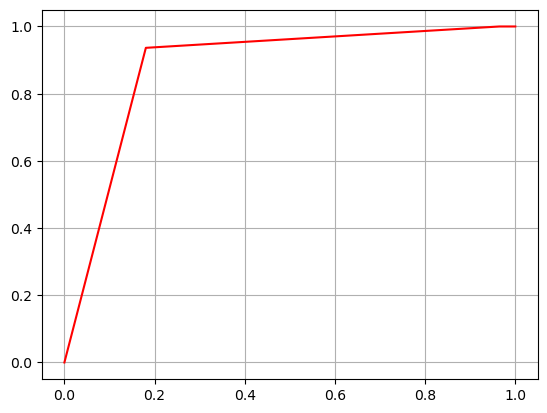

In [ ]:
ts = jnp.ones_like(labels[-1000:]) * t
mean, std = jax.vmap(sde.marginal_prob)(images[-1000:], ts)
z = jax.random.normal(rng, mean.shape)
perturbed_images = mean + jax.vmap(batch_mul)(std, z)

vapply = jax.vmap(lambda img, t: ckpt_model_state.apply_fn({'params': ckpt_model_state.params}, img, t, train=False, mutable=False))
logits = vapply(images[-1000:], ts)
probas = nn.sigmoid(logits).reshape(-1, 1)

def confusion(pred, true):
    p = jnp.sum(true)
    n = jnp.sum(1. - true)
    tpr = jnp.sum(pred * true) / p
    tnr = jnp.sum((1. - pred) * (1. - true)) / n

    return tpr, 1. - tnr

gt = labels[-1000:].reshape(-1, 1)
thresholds = jnp.linspace(0., 1., 100)
tpr, fpr = jax.vmap(lambda t: confusion(1. * (probas > t), gt))(thresholds)
diff = fpr[:-1] - fpr[1:]
eval_loss = jnp.mean(optax.sigmoid_binary_cross_entropy(logits.reshape(-1, 1), gt))

print(f'Eval loss: {eval_loss}')
print(f'AUROC: {jnp.sum(tpr[1:] * diff)}')
plt.plot(fpr, tpr, 'r-')
plt.grid()
plt.show()

# Logistic Regression example for reference

Eval loss: 0.3035017251968384
AUROC: 0.9421277046203613


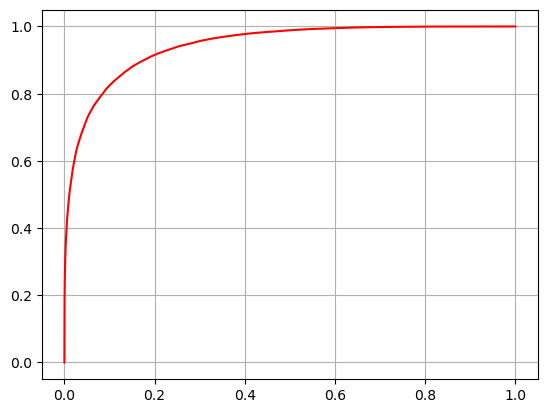

In [ ]:
from flax import linen as nn
import jax
from jax import numpy as jnp
import optax
from flax.training.train_state import TrainState
from matplotlib import pyplot as plt

rng = jax.random.PRNGKey(42)

model = nn.Dense(1, use_bias=False)
variables = model.init({'params': rng}, jnp.zeros((1, 1, 2)), mutable=True)
init_params = variables['params']

optim = optax.sgd(1e-2)
state = TrainState.create(apply_fn=model.apply, params=init_params, tx=optim)

rng, x_rng = jax.random.split(rng)
X = jax.random.normal(x_rng, (10000, 128, 2))
rng, w_rng = jax.random.split(rng)
w = jax.random.normal(w_rng, (2,)) * 3.
rng, y_rng = jax.random.split(rng)
y = jax.random.bernoulli(y_rng, nn.sigmoid(X @ w))

def train_step(state: TrainState, batch):
    
    def loss_fn(params, data, label):
        logits = state.apply_fn({'params': params}, data)
        return jnp.mean(optax.sigmoid_binary_cross_entropy(logits[:, 0], label))

    grad_fn = jax.value_and_grad(loss_fn)
    data, label = batch

    loss, grad = grad_fn(state.params, data, label)
    new_state = state.apply_gradients(grads=grad)

    return new_state, loss


new_state, loss = jax.lax.scan(train_step, state, (X[:-1000], y[:-1000]))

logits = new_state.apply_fn({'params': new_state.params}, X[-1000:], mutable=False)
probas = nn.sigmoid(logits).reshape(-1, 1)

def confusion(pred, true):
    p = jnp.sum(true)
    n = jnp.sum(1. - true)
    tpr = jnp.sum(pred * true) / p
    tnr = jnp.sum((1. - pred) * (1. - true)) / n

    return tpr, 1. - tnr

gt = y[-1000:].reshape(-1, 1)
thresholds = jnp.linspace(0., 1., 100)
tpr, fpr = jax.vmap(lambda t: confusion(1. * (probas > t), gt))(thresholds)
diff = fpr[:-1] - fpr[1:]
eval_loss = jnp.mean(optax.sigmoid_binary_cross_entropy(logits.reshape(-1, 1), gt))

print(f'Eval loss: {eval_loss}')
print(f'AUROC: {jnp.sum(tpr[1:] * diff)}')
plt.plot(fpr, tpr, 'r-')
plt.grid()
plt.show()